In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

class BacktrackAttempt:
    def __init__(self, matrix, index,options):
        self.matrix=matrix.copy()
        self.index=index
        self.options=options
        self.n=len(options)
        self.i=0

class BacktrackAttempts:
    def __init__(self):
        self.attempts=[]
        self.n=0
    def addNewAttempt(self,attempt):
        self.attempts.append(attempt)
        self.n+=1
    def nextAttempt(self):        
        found=False
        while (found==False and self.n>0):
            attempt=self.attempts[-1]
            if attempt.i<attempt.n:
                matrix=attempt.matrix.copy()
                matrix[attempt.index]=attempt.options[attempt.i]
                attempt.i+=1
                found=True
            else:     
                self.attempts.pop()
                self.n-=1
        if found==False:
            raise ValueError('There are no more available attempts')
        return matrix

class SudokuSolver:
    def __init__(self,sudoku,plot=False):
        self.shape=sudoku.shape
        self.original=sudoku.flatten()
        self.current=self.original.copy()
        self.stackbacktrack=BacktrackAttempts()
        self.plot=plot
        
        self.regions=[]
        rows=self.shape[0]
        columns=self.shape[1]
        inds=np.arange(rows*columns)
        for i in range(rows):
            region=(inds>=columns*i)*(inds<columns*(i+1))
            self.regions.append(region)
        for i in range(columns):
            region=(inds%columns==i)
            self.regions.append(region)
            
        for i in range(0,rows,3):
            for j in range(0,columns,3):
                region=(inds%columns>=j)*(inds%columns<j+3)*(inds>=columns*i)*(inds<columns*(i+3))
                self.regions.append(region)
        
        self.rows=rows
        self.columns=columns
        
        if self.plot:
            self.enablePlot()
            
    def enablePlot(self):
        self.fig=plt.figure(figsize=(8, 8)) # supoose I know what the limits are going to be
        self.ax=self.fig.add_subplot('111')
        self.ax.set_xlim(-1,self.columns)
        self.ax.set_ylim(-1,self.rows)    
        self.ax.set_frame_on(False)
        self.ax.axes.get_yaxis().set_visible(False)
        self.ax.axes.get_xaxis().set_visible(False)
        plt.ion()
        plt.show()
        self.plotCurrent()
        self.plot=True
            
    def showOriginal(self):
        print ""
        print self.original.reshape(self.shape)
        
    def showCurrent(self):
        print ""
        print self.current.reshape(self.shape)    
        
    def plotCurrent(self):
        if self.plot:
            self.ax.cla() 
            values=self.current.reshape(self.shape)  
            original=self.original.reshape(self.shape)  
            for i in range(self.rows):
                for j in range(self.columns):          
                    if values[i,j]>0:
                        if original[i,j]!=0:
                            self.ax.text(j,self.rows-i-1,'%i'%values[i,j],ha='center',va='center',fontsize=18,fontweight='bold',color=(0.7,0,0))
                        else:
                            self.ax.text(j,self.rows-i-1,'%i'%values[i,j],ha='center',va='center',fontsize=18)
            
            alphas=np.linspace(0.75,0.25,len(self.stackbacktrack.attempts))
            for i,attempt in enumerate(self.stackbacktrack.attempts):
                row=attempt.index/self.columns
                column=attempt.index%self.columns
                self.circle1=self.ax.add_artist(plt.Circle((column,self.rows-row-1),.38,color='r',alpha=alphas[i]))
                            
            for i in range(self.rows+1):
                linewidth=1
                if i%3==0:
                    linewidth=3
                self.ax.plot([-0.5,self.columns-0.5],[i-0.5,i-0.5],color='k',linewidth=linewidth) 
            for i in range(self.columns+1):
                linewidth=1
                if i%3==0:
                    linewidth=3
                self.ax.plot([i-0.5,i-0.5],[-0.5,self.rows-0.5],color='k',linewidth=linewidth) 

            display.clear_output(wait=True)
            display.display(self.fig) 
            time.sleep(0.01)
        
    def checkCurrent(self):
        for region in self.regions:
            numbers=self.current[(region)*(self.current!=0)]
            if (np.unique(numbers,return_counts=True)[1].max()>1):
                return False            
        return True
    
    def fillSimpleNumbers(self,ret_suggestion=False):
        badvaluesarray=np.zeros((self.rows*self.columns,3*9))
        badvaluesarraycount=np.zeros((self.rows*self.columns,1))
        for region in self.regions:
            badvalues=self.current[(region)*(self.current!=0)]
            badvaluescount=len(badvalues)
            badvaluetargets=np.where((region)*(self.current==0))[0]
            
            for i in badvaluetargets:
                badvaluesarray[i,badvaluesarraycount[i]:badvaluesarraycount[i]+badvaluescount]=badvalues
                badvaluesarraycount[i]+=badvaluescount
        
        newvalues=0
        maxunique=-1
        maxuniqueind=-1
        for i in np.where((self.current==0))[0]:                        
            uniquevals=np.unique(badvaluesarray[i,:])        
            if(len(uniquevals)-1==8):
                numbermissing=45-(uniquevals[1:].sum())# This gives the numbers missing
                self.current[i]=numbermissing
                newvalues+=1       
            if(len(uniquevals)-1>=9):
                if ret_suggestion:
                    return -1,-1,-1;
                else:
                    return -1;
            if len(uniquevals)-1>maxunique:
                maxunique=len(uniquevals)-1
                maxuniqueind=i
                                        
        if ret_suggestion:
            uniquevals=np.unique(badvaluesarray[maxuniqueind,:])  
            candidates=list(set(range(10)) - set(uniquevals))
            return newvalues,maxuniqueind,candidates
        else:
            return newvalues
                
    def isSolved(self):
        if len(np.where(self.current==0)[0])==0 and self.checkCurrent():
            return True
        return False
    
    def solve(self,ploteach=100):
        countplot=0
        self.maxstack=0
        while (not self.isSolved()):  
            newnumbers,maxuniqueind,candidates=self.fillSimpleNumbers(True)            
                        
            if newnumbers==-1 or not self.checkCurrent():   
                try:
                    matrix=self.stackbacktrack.nextAttempt()
                except ValueError:
                    print 'Impossible to solve'
                    break
                if (matrix is None):
                    break
                self.current=matrix    
            elif newnumbers==0:
                ba=BacktrackAttempt(self.current,maxuniqueind,candidates)
                self.stackbacktrack.addNewAttempt(ba)
                matrix=self.stackbacktrack.nextAttempt()
                self.current=matrix 
            
            if countplot==ploteach and self.plot:
                self.plotCurrent()                
                countplot=0
            countplot+=1 
            
            if (self.stackbacktrack.n>self.maxstack):
                self.maxstack=self.stackbacktrack.n
        if self.plot:        
            self.plotCurrent()

In [ ]:
S_easy=[[0,0,0,0,0,0,0,7,3],
   [4,0,8,0,0,0,0,0,0],
   [0,3,1,4,5,0,0,0,0],
   [0,0,7,0,0,0,2,9,8],
   [0,0,5,2,0,7,3,0,0],
   [9,2,4,0,0,0,6,0,0],
   [0,0,0,0,1,3,9,6,0],
   [0,0,0,0,0,0,7,0,5],
   [8,4,0,0,0,0,0,0,0]]
            
            
S_hard=[[8,0,0,0,0,0,0,0,0],
   [0,0,3,6,0,0,0,0,0],
   [0,7,0,0,9,0,2,0,0],
   [0,5,0,0,0,7,0,0,0],
   [0,0,0,0,4,5,7,0,0],
   [0,0,0,1,0,0,0,3,0],
   [0,0,1,0,0,0,0,6,8],
   [0,0,8,5,0,0,0,1,0],
   [0,9,0,0,0,0,4,0,0]]

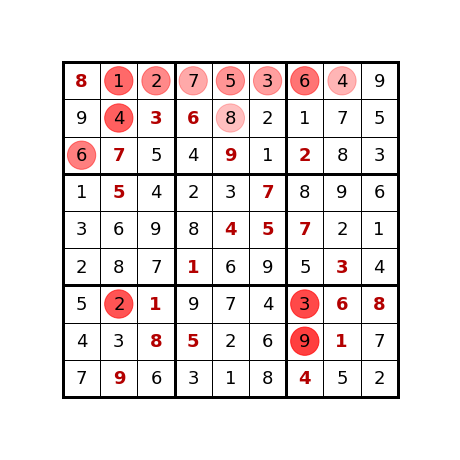

16


In [12]:
#Graphical display as it is being solved
S=np.array(S_hard)
ss=SudokuSolver(S,plot=True)
ss.plotCurrent()
ss.solve(ploteach=50)
ss.plotCurrent()
print ss.maxstack

In [9]:
#Just the solution
S=np.array(S_hard)
ss=SudokuSolver(S)
ss.showOriginal()
ss.solve()
ss.showCurrent()


[[8 0 0 0 0 0 0 0 0]
 [0 0 3 6 0 0 0 0 0]
 [0 7 0 0 9 0 2 0 0]
 [0 5 0 0 0 7 0 0 0]
 [0 0 0 0 4 5 7 0 0]
 [0 0 0 1 0 0 0 3 0]
 [0 0 1 0 0 0 0 6 8]
 [0 0 8 5 0 0 0 1 0]
 [0 9 0 0 0 0 4 0 0]]

[[8 1 2 7 5 3 6 4 9]
 [9 4 3 6 8 2 1 7 5]
 [6 7 5 4 9 1 2 8 3]
 [1 5 4 2 3 7 8 9 6]
 [3 6 9 8 4 5 7 2 1]
 [2 8 7 1 6 9 5 3 4]
 [5 2 1 9 7 4 3 6 8]
 [4 3 8 5 2 6 9 1 7]
 [7 9 6 3 1 8 4 5 2]]
